<a id="top"></a>
# Starbucks Capstone Challenge

## Overview

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

The task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

Transactional data shows user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. It also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

#### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

#### Tips

Take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. Therefore, try to assess what a certain demographic group will buy when not receiving any offers.

## Objectives

In this notebook, I will develop heurisitics to determine which offer should be sent and how spends vary across customers with demographics.

Based on the findings, two machine learning models will be built:
- a classification model to predict whether or not a customer will respond to an offer
- a regression model to predict spends of customers based on demographics and offer type

## Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

# Table of contents

This project is divided into two Jupyter Notebooks.

- wrangling.ipynb
- analysis.ipynb

This notebook (`wrangling.ipynb`) starts the project by data wrangling works as following:

1. Load packages and data 
2. Understand data [link](data):
    - portfolio
    - profile
    - transcript
    
A seperate `analysis.ipynb` notebook continues with analysis.

## SECTION 1

## 1a. Importing libraries

In [1]:
# data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import math

# utils
import os
import json
import pickle
from tqdm import tqdm 

%matplotlib inline

## 1b. Importing data

In [2]:
# read in the json files
ORIGINAL_DATA_ROOT = './data/original/'

portfolio = pd.read_json(ORIGINAL_DATA_ROOT + 'portfolio.json', orient='records', lines=True)
profile = pd.read_json(ORIGINAL_DATA_ROOT + 'profile.json', orient='records', lines=True)
transcript = pd.read_json(ORIGINAL_DATA_ROOT + 'transcript.json', orient='records', lines=True)

---
<span a id="data"></span>
## SECTION 2 Understand data

### 2a. portfolio dataset

In [3]:
print('Portfolio dataset size:', portfolio.shape[0])
portfolio.head()

Portfolio dataset size: 10


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


There are 10 offers available in the data as it is a simplified version. 

For cleaning, I will check:
- no missing / duplicated value 
- correct date types 
- `channels` column to be destructured

In [4]:
# Function to clean 'portfolio' data 

def clean_portfolio(df):
    ''' Clean the 'portolio' dataset, achieving :
    1. Destructure 'channels' column
    2. Drop 'channels' column after destructing
    
    INPUT: a Pandas dataframe that contains portfolio data
    OUTPUT: a clean dataframe 
    '''
    
    # Extract unique channels 
    channel_set = set()

    for row in df.channels:
        for ch in row:
            channel_set.add(ch)
    

    # Create binary tables for channels
    channel_bool = dict()

    for ch in channel_set:
        channel_bool[ch] = df.channels.apply(lambda x: ch in x)
    
    channel_df = pd.DataFrame(channel_bool)
    
    # Transform boolean to binary integer (True: 1, False: 0)
    binary_rule = {True: 1, False: 0}
    
    for ch in channel_df.columns:
        channel_df[ch] = channel_df[ch].map(binary_rule) 
       
    # Join the binary columns to the original dataframe
    df_output = df.join(channel_df)
        
    
    # Drop 'channels' columns
    df_output = df_output.drop(columns='channels')
    
    return df_output
    

In [5]:
# Clean portfolio dataframe

portfolio_clean = clean_portfolio(portfolio)
portfolio_clean.head()

,reward,difficulty,duration,offer_type,id,web,email,social,mobile
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0


In [6]:
# Check for duplicates

assert np.all(portfolio_clean.duplicated() == 0), "At least one duplicated record found"

In [7]:
# Saving the cleand dataframe as 'portfolio_clean'

portfolio_clean.to_csv('data/portfolio_clean.csv', index=False)

### 2b. profile dataset

In [8]:
print('Profile dataset size:', profile.shape[0])
profile.head() 

Profile dataset size: 17000


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [9]:
# Check for duplicates by id

assert np.all(profile.duplicated(subset='id') == 0), "At least one duplicated record found"

In [10]:
# Check for missing values

profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [11]:
# Check for inconsistent data

profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [12]:
# Data records with age = 118

profile.query('age == 118').isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

There is no duplicated id. Abnormal data records found where age = 118. It appears that those records attribute to missing values (assuming that age = 118 is a set test records).

For cleaning, handle 
- 2175 missing values (age of 118)
- data type for **became_member_on** column (numeric -> datetime object)

In [13]:
### Function to clean 'profile' data

def clean_profile(df):
    ''' Clean the 'portolio' dataset, achieving :
    1. Drop nulls (those age = 18)
    2. Convert 'become_member_on' to datetime object
    
    INPUT: a Pandas dataframe that contains profile data
    OUTPUT: a clean dataframe 
    '''
    
    # Filter out abnormal data records
    df_clean = df.query('age != 118').copy()
    
    # Convert to datetime object
    df_clean.loc[:, 'became_member_on'] = pd.to_datetime(df_clean.became_member_on, format="%Y%m%d")
    
    return df_clean


In [14]:
profile_clean = clean_profile(profile)

# Check for any remaining null data 
assert profile_clean.shape[0] == profile.shape[0] - 2175, "It looks that missing values are not dropped correctly"
assert np.all(profile_clean.isnull().sum()) == 0, "There still is missing value"

In [15]:
# Save the clean data 

profile_clean.to_csv('data/profile_clean.csv', index=False)

### 2c. transcript dataset

In [16]:
transcript.head(3)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0


In [17]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [18]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

There are four unique events identified.

Following the overview, the sequence of the event should be: offer received -> offer viewed -> offer transaction -> offer completed. <br>
Also, it is important to note that offer is not actually redeemed if offer is completed without viewing.

In [19]:
# Quick inspection over value column
# Destructoring dictionary in 'value' column 

# Extract unique keys from the dictionary
value_sets = set()

for record in transcript.value:
    for key in record.keys():
        value_sets.add(key)
        
print(value_sets)

{'reward', 'offer_id', 'offer id', 'amount'}


There are four unique types of information found in **value** column, while 'offer_id' and 'offer id' repeat.

For cleaning, handle

- value column to be destructured into 4 columns
- combine 'offer_id' and 'offer id' column into 'offer_id' 
- drop 'offer id' column

In [20]:
# Function to clean 'transcript' data

def clean_transcript(df):
    ''' Clean the 'transcript' dataset, achieving :
    1. Destructure dictionary in 'value' column & create a new dataframe
    2. Ensure consistency by merging offer_id with offer id column
    3. Drop the duplicated offer id column
    3. Join the new dataframe to the original transcript dataframe
    4. Drop the original 'value' column

    INPUT: a Pandas dataframe that contains transcript data
    OUTPUT: a clean dataframe 
    '''
    
    # Instantiate df_clean as a copy of df
    df_clean = df.copy()
    
    # Destructoring dictionary in 'value' column 
    value_df = pd.json_normalize(df.value)
    
    # Making values in 'value_key' column consistent + testing the result
    # 'offer id' column merged 'offer_id' & test the change

    # For testing, the merged column size should match sum of count 1 & 2
    count1 = value_df['offer_id'].notnull().sum()
    count2 = value_df['offer id'].notnull().sum()
    
    offer_id_arr = np.where(value_df['offer id'].notnull(), value_df['offer id'], value_df['offer_id'])
    
    # Drop offer id columns
    value_df = value_df.drop(columns=['offer id', 'offer_id'])
    
    # Add the array as the new 'offer_id' column
    value_df['offer_id'] = offer_id_arr

    # Join value_df to the original transcript dataframe
    df_clean = df_clean.join(value_df)
    
    # Drop the 'value' column
    df_clean = df_clean.drop(columns='value')
    
    return df_clean
    

In [21]:
# Returning the clean dataframe

transcript_clean = clean_transcript(transcript)
transcript_clean.head()

,person,event,time,amount,reward,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


#### Post cleaning inspection for **transcript_clean**
**transcript** contains transactions data that the other (profile, portfolio) dataframes should be dependent on. <br>
We need to ensure that the cleaning **transcript** has been done correctly.

All the duplicated records are related to **offer completed** event. Let's inspect duplicated records with a sample.

In [22]:
# Check for duplicated records

dup_transcript = transcript_clean[transcript_clean.duplicated(keep=False)]
dup_transcript

,person,event,time,amount,reward,offer_id
66122,3dde94fa581145cb9f206624f1a94d5a,offer completed,168,NaN,2.0,2906b810c7d4411798c6938adc9daaa5
66123,3dde94fa581145cb9f206624f1a94d5a,offer completed,168,NaN,2.0,2906b810c7d4411798c6938adc9daaa5
66782,e9fb6ed2cecb4980ba98c86abc9c91e3,offer completed,168,NaN,10.0,ae264e3637204a6fb9bb56bc8210ddfd
66783,e9fb6ed2cecb4980ba98c86abc9c91e3,offer completed,168,NaN,10.0,ae264e3637204a6fb9bb56bc8210ddfd
67613,a7dc060f6fc94ca7bf71fbb188187dca,offer completed,168,NaN,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9
...,...,...,...,...,...,...
304756,0785f1fce0b04ba08e01c7d2ebab4917,offer completed,708,NaN,5.0,0b1e1539f2cc45b7b9fa7c272da2e1d7
305550,b7e216b6472b46648272c29a52a86702,offer completed,714,NaN,2.0,fafdcd668e3743c1bb461111dcafc2a4
305551,b7e216b6472b46648272c29a52a86702,offer completed,714,NaN,2.0,fafdcd668e3743c1bb461111dcafc2a4
306455,f3e801caeafe4899b3b989b586e74ac7,offer completed,714,NaN,5.0,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [23]:
# Unique event pattern for duplicated fields

dup_transcript.event.unique()

array(['offer completed'], dtype=object)

In [24]:
# Sample fields for duplication

dup_transcript.query('person == "a7dc060f6fc94ca7bf71fbb188187dca"')

,person,event,time,amount,reward,offer_id
67613,a7dc060f6fc94ca7bf71fbb188187dca,offer completed,168,NaN,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9
67614,a7dc060f6fc94ca7bf71fbb188187dca,offer completed,168,NaN,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9


About 397 pairs of records (793 duplicated rows / 2) are duplicated. The duplicated records commonly come from **offer completed** event only. <br>
The duplicated fields do not provide additional information, so will be dropped.

In [25]:
transcript_clean = transcript_clean.drop_duplicates(keep='first')
assert transcript_clean.shape[0] == 306534 - 397, 'Dropping duplicates has an error.'

In [26]:
# Save the clean data 

transcript_clean.to_csv('data/transcript_clean.csv', index=False)

### 2d. Labelling

Here, I will explore the transactions through unique events and label if a transaction is complete or incomplete.

Following the overview, it is important to note that
- the sequence of the event should be: offer received -> offer viewed -> offer transaction -> offer completed. 
- offer is not actually redeemed if offer is completed without viewed
- informational offer does not involve transaction 

There are four unique events identified for transactions (**transcript** dataframe). For the ease of analysis, we transform `event` column categorical, ordered following funnels.

#### Data transformation

In [27]:
# Unique events

transcript_clean['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [28]:
# Transform event column into categorical ordered dtype

funnel_orders = ['offer received', 'offer viewed', 'transaction', 'offer completed']
transcript_clean.event = pd.Categorical(transcript_clean.event, categories=funnel_orders, ordered=True)

In [29]:
# Sorting the dataframe by person, time and event
# will represent dataframe in order of event(funnel) for each offer

transcript_sorted = transcript_clean.sort_values(by=['person', 'time', 'event'], ascending=True)
transcript_sorted

,person,event,time,amount,reward,offer_id
55972,0009655768c64bdeb2e877511632db8f,offer received,168,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
77705,0009655768c64bdeb2e877511632db8f,offer viewed,192,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
89291,0009655768c64bdeb2e877511632db8f,transaction,228,22.16,NaN,NaN
113605,0009655768c64bdeb2e877511632db8f,offer received,336,NaN,NaN,3f207df678b143eea3cee63160fa8bed
139992,0009655768c64bdeb2e877511632db8f,offer viewed,372,NaN,NaN,3f207df678b143eea3cee63160fa8bed
...,...,...,...,...,...,...
258361,ffff82501cea40309d5fdd7edcca4a07,transaction,576,14.23,NaN,NaN
258362,ffff82501cea40309d5fdd7edcca4a07,offer completed,576,NaN,2.0,2906b810c7d4411798c6938adc9daaa5
262475,ffff82501cea40309d5fdd7edcca4a07,offer viewed,582,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
274809,ffff82501cea40309d5fdd7edcca4a07,transaction,606,10.12,NaN,NaN


In [30]:
# Explore transaction records for a sample person(customer) 

transcript_sorted.query('person == "0009655768c64bdeb2e877511632db8f"')

,person,event,time,amount,reward,offer_id
55972,0009655768c64bdeb2e877511632db8f,offer received,168,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
77705,0009655768c64bdeb2e877511632db8f,offer viewed,192,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
89291,0009655768c64bdeb2e877511632db8f,transaction,228,22.16,NaN,NaN
113605,0009655768c64bdeb2e877511632db8f,offer received,336,NaN,NaN,3f207df678b143eea3cee63160fa8bed
139992,0009655768c64bdeb2e877511632db8f,offer viewed,372,NaN,NaN,3f207df678b143eea3cee63160fa8bed
153401,0009655768c64bdeb2e877511632db8f,offer received,408,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d
168412,0009655768c64bdeb2e877511632db8f,transaction,414,8.57,NaN,NaN
168413,0009655768c64bdeb2e877511632db8f,offer completed,414,NaN,5.0,f19421c1d4aa40978ebb69ca19b0e20d
187554,0009655768c64bdeb2e877511632db8f,offer viewed,456,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d
204340,0009655768c64bdeb2e877511632db8f,offer received,504,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4


The records show a sequence of transactions for a person(customer). It shows some incorrect offer completion such as:
- a missing offer completed event after transaction (offer id# 5a8bc65990b245e5a138643cd4eb9837)
- an offer viewed after transaction (offer id# f19421c1d4aa40978ebb69ca19b0e20d)
- transaction without offer viewed (offer id# 2906b810c7d4411798c6938adc9daaa5)

In [31]:
portfolio_clean.query('offer_type == "informational"').id

2    3f207df678b143eea3cee63160fa8bed
7    5a8bc65990b245e5a138643cd4eb9837
Name: id, dtype: object

It appers that informational offers (3f207df678b143eea3cee63160fa8bed, 5a8bc65990b245e5a138643cd4eb9837) has a different funnel: offer received -> offer viewed. This explains why there was a missing offer completed event after transaction.

Next, in order to label if a transaction is complete or incomplete, a data transformation is needed using pivot table. In the table, the sequence of funnel should be in  column where as each row should show unique data by person(customer) and offer. The record time will be used as a value so it is clear when exactly a certain event happened.

In [32]:
# Subset the transript dataframe
# using necessary features only

transcript_subset = transcript_sorted[['person','event','time','offer_id']]
transcript_subset

,person,event,time,offer_id
55972,0009655768c64bdeb2e877511632db8f,offer received,168,5a8bc65990b245e5a138643cd4eb9837
77705,0009655768c64bdeb2e877511632db8f,offer viewed,192,5a8bc65990b245e5a138643cd4eb9837
89291,0009655768c64bdeb2e877511632db8f,transaction,228,NaN
113605,0009655768c64bdeb2e877511632db8f,offer received,336,3f207df678b143eea3cee63160fa8bed
139992,0009655768c64bdeb2e877511632db8f,offer viewed,372,3f207df678b143eea3cee63160fa8bed
...,...,...,...,...
258361,ffff82501cea40309d5fdd7edcca4a07,transaction,576,NaN
258362,ffff82501cea40309d5fdd7edcca4a07,offer completed,576,2906b810c7d4411798c6938adc9daaa5
262475,ffff82501cea40309d5fdd7edcca4a07,offer viewed,582,2906b810c7d4411798c6938adc9daaa5
274809,ffff82501cea40309d5fdd7edcca4a07,transaction,606,NaN


In [33]:
## Create a pivot table 
# unique row: person and offer
# column: 4 events
# value: time

transaction_by_customer = transcript_subset.groupby(['person', 'offer_id', 'event']).min().unstack()
transaction_by_customer.columns = transaction_by_customer.columns.droplevel(0) # reset multi-index column
transaction_by_customer

event                                                              offer received  \
person                           offer_id                                           
0009655768c64bdeb2e877511632db8f 0b1e1539f2cc45b7b9fa7c272da2e1d7             NaN   
                                 2298d6c36e964ae4a3e7e9706d1fb8c2             NaN   
                                 2906b810c7d4411798c6938adc9daaa5           576.0   
                                 3f207df678b143eea3cee63160fa8bed           336.0   
                                 4d5c57ea9a6940dd891ad53e9dbe8da0             NaN   
...                                                                           ...   
ffff82501cea40309d5fdd7edcca4a07 5a8bc65990b245e5a138643cd4eb9837             NaN   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9           504.0   
                                 ae264e3637204a6fb9bb56bc8210ddfd             NaN   
                                 f19421c1d4aa40978ebb69ca19b0e20d             NaN   
                                 fafdcd668e3743c1bb461111dcafc2a4             0.0   

event                                                              offer viewed  \
person                           offer_id                                         
0009655768c64bdeb2e877511632db8f 0b1e1539f2cc45b7b9fa7c272da2e1d7           NaN   
                                 2298d6c36e964ae4a3e7e9706d1fb8c2           NaN   
                                 2906b810c7d4411798c6938adc9daaa5           NaN   
                                 3f207df678b143eea3cee63160fa8bed         372.0   
                                 4d5c57ea9a6940dd891ad53e9dbe8da0           NaN   
...                                                                         ...   
ffff82501cea40309d5fdd7edcca4a07 5a8bc65990b245e5a138643cd4eb9837           NaN   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9         534.0   
                                 ae264e3637204a6fb9bb56bc8210ddfd           NaN   
                                 f19421c1d4aa40978ebb69ca19b0e20d           NaN   
                                 fafdcd668e3743c1bb461111dcafc2a4           6.0   

event                                                              transaction  \
person                           offer_id                                        
0009655768c64bdeb2e877511632db8f 0b1e1539f2cc45b7b9fa7c272da2e1d7          NaN   
                                 2298d6c36e964ae4a3e7e9706d1fb8c2          NaN   
                                 2906b810c7d4411798c6938adc9daaa5          NaN   
                                 3f207df678b143eea3cee63160fa8bed          NaN   
                                 4d5c57ea9a6940dd891ad53e9dbe8da0          NaN   
...                                                                        ...   
ffff82501cea40309d5fdd7edcca4a07 5a8bc65990b245e5a138643cd4eb9837          NaN   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9          NaN   
                                 ae264e3637204a6fb9bb56bc8210ddfd          NaN   
                                 f19421c1d4aa40978ebb69ca19b0e20d          NaN   
                                 fafdcd668e3743c1bb461111dcafc2a4          NaN   

event                                                              offer completed  
person                           offer_id                                           
0009655768c64bdeb2e877511632db8f 0b1e1539f2cc45b7b9fa7c272da2e1d7              NaN  
                                 2298d6c36e964ae4a3e7e9706d1fb8c2              NaN  
                                 2906b810c7d4411798c6938adc9daaa5            576.0  
                                 3f207df678b143eea3cee63160fa8bed              NaN  
                                 4d5c57ea9a6940dd891ad53e9dbe8da0              NaN  
...                                                                            ...  
ffff82501cea40309d5fdd7edcca4a07 5a8bc65990b245e5a138643cd4eb9837  

In [34]:
# Inspect if all persons have 10 offers using progress bar
# May take up to 2-3 minutes

member_ids = transcript_subset.person

for _id in tqdm(member_ids):
    assert transaction_by_customer.loc[_id].shape[0] == 10

100%|██████████| 306137/306137 [02:22<00:00, 2145.27it/s]


The pivot table has 10 unique offers for each person. **transaction** column has no data as **offer_id** is not given for the transaction. Therefore, it should later be added.

#### Label offer complete / incomplete

There are 5 possible behaviours identified through the funnels and each will be labeled as following.

1. complete
2. inactive : incomplete, no purchase after offer viewed
3. active   : incomplete, but purchased without offer viewed
4. indifferent: incomplete, no purchase no view
5. not received 


<style>
table {float:left}
</style>

| Offer received 	| Offer viewed 	| Transaction 	| Offer completed 	| Label 	|
|:--------------:	|:------------:	|:-----------:	|:---------------:	|:-----:	|
|        o       	|       o      	|     NaN     	|        o        	|   1   	|
|        o       	|       o      	|     NaN     	|        x        	|   2   	|
|        o       	|       x      	|     NaN     	|        o        	|   3   	|
|        o       	|       x      	|     NaN     	|        x        	|   4   	|
|        x       	|       x      	|     NaN     	|        x        	|   5   	|

In [35]:
# Function to label transactions

def label_transactions(df):
    ''' Create a new dataframe that contains label column
    to represent the status of offer. The column will contain five labels in integer
    
    INPUT: a pivoted dataframe that contains funnel information by
        customer(person) and offer(offer_id)
        
    OUTPUT: a dataframe that has either of the three labels attached    
    '''
        
    
    # Map the transactions data 
    # if there is a value = 1, or 0    
    data = np.where(df.notnull(), 1, 0)
    
    # Instantiate label output
    labels = np.zeros(data.shape[0])
        
    # row[0] = offer received
    # row[1] = offer viewed
    # row[2] = transaction    
    # row[3] = offer completed
    
    for i, row in enumerate(data):              
        
        if row[0] and row[1] and row[3]:
            labels[i] = 1

        elif row[0] and row[1] and not row[3]:
            labels[i] = 2

        elif row[0] and not row[1] and row[3]:
            labels[i] = 3

        elif row[0] and not row[1] and not row[3]:
            labels[i] = 4
            
        else:
            labels[i] = 5

    return labels

In [36]:
# Create labels

labels = label_transactions(transaction_by_customer)
labels

array([5., 5., 3., ..., 5., 5., 1.])

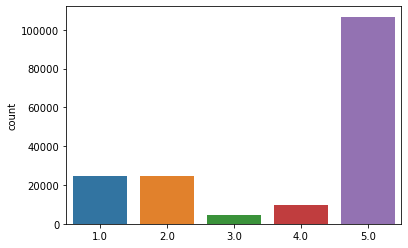

In [37]:
# Visualize labels

sns.countplot(x=labels);

There are large amounts of **unsent** records (4: label).

#### Merge into a final pivot table

In [39]:
## Add labels to each transaction

# Change data type for columns : categorical -> str
# otherwise, a new column cannot be added

transaction_by_customer.columns = transaction_by_customer.columns.astype(str)
transaction_by_customer['label'] = labels
transaction_by_customer = transaction_by_customer.reset_index()

In [40]:
## Add amount and reward columns back to the pivot table

# Create subset with necessary columns only

transactions_subset = transcript_sorted[transcript_sorted['amount'].notnull()].drop(columns=['event', 'reward', 'offer_id'])
rewards_subset = transcript_sorted[transcript_sorted['reward'].notnull()].drop(columns=['event', 'amount'])

# Merge dataframes
transactions_merged = pd.merge(transaction_by_customer, transactions_subset, how='left', left_on=['person', 'offer completed'], right_on=['person', 'time'])
transactions_merged.drop(columns=['time'], inplace=True)

transactions_merged = pd.merge(transactions_merged, rewards_subset, how='left', left_on=['person', 'offer_id', 'offer completed'], right_on=['person', 'offer_id', 'time'])
transactions_merged.drop(columns=['time'], inplace=True)

In [41]:
transactions_merged.head()

,person,offer_id,offer received,offer viewed,transaction,offer completed,label,amount,reward
0,0009655768c64bdeb2e877511632db8f,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,NaN,5.0,NaN,NaN
1,0009655768c64bdeb2e877511632db8f,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN,NaN,NaN,5.0,NaN,NaN
2,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576.0,NaN,NaN,576.0,3.0,10.27,2.0
3,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336.0,372.0,NaN,NaN,2.0,NaN,NaN
4,0009655768c64bdeb2e877511632db8f,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN,NaN,5.0,NaN,NaN


#### Handling incorrect labeling

There are transactions where a customer viewed an offer after offer completed. This case shouldn't be counted completed as offer itself did not influence purchasing decision.

The previous data wrangling assumed the dataframe was ordered by time through funnels so couldn't catch this exceptional case. There are over 3708 records that are incorrectly labeled, which need an additional adjustment.

In [45]:
incorrect_labels = transactions_merged[transactions_merged['offer viewed'] > transactions_merged['offer completed']]
incorrect_labels

,person,offer_id,offer received,offer viewed,transaction,offer completed,label,amount,reward
8,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408.0,456.0,NaN,414.0,1.0,8.57,5.0
9,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,504.0,540.0,NaN,528.0,1.0,14.11,2.0
101,0056df74b63b4298809f0b375a304cf4,2298d6c36e964ae4a3e7e9706d1fb8c2,576.0,654.0,NaN,576.0,1.0,29.77,3.0
130,00715b6e55c3431cb56ff7307eb19675,0b1e1539f2cc45b7b9fa7c272da2e1d7,168.0,228.0,NaN,210.0,1.0,28.73,5.0
132,00715b6e55c3431cb56ff7307eb19675,2906b810c7d4411798c6938adc9daaa5,504.0,564.0,NaN,534.0,1.0,21.35,2.0
...,...,...,...,...,...,...,...,...,...
169947,fff29fb549084123bd046dbc5ceb4faa,ae264e3637204a6fb9bb56bc8210ddfd,0.0,642.0,NaN,168.0,1.0,15.16,10.0
169948,fff29fb549084123bd046dbc5ceb4faa,f19421c1d4aa40978ebb69ca19b0e20d,408.0,438.0,NaN,426.0,1.0,24.56,5.0
169956,fff3ba4757bd42088c044ca26d73817a,9b98b8c7a33c4b65b9aebfe6a799e6d9,168.0,210.0,NaN,168.0,1.0,22.76,5.0
169986,fffad4f4828548d1b5583907f2e9906b,9b98b8c7a33c4b65b9aebfe6a799e6d9,576.0,666.0,NaN,588.0,1.0,10.98,5.0


In [46]:
# Adjusting the incorrect labeling
# It is equivalent to incomplete - no viewe, purchased (label 3)

transactions_merged.loc[transactions_merged['offer viewed'] > transactions_merged['offer completed'], 'label'] = 3

#### Readjusting labels for informational offers

There are two information offers and they only have two possible events: offer received and offer viewed. Therefore, we consider it completed when the two events are made.

In [47]:
info_offer_ids = portfolio_clean.query('offer_type == "informational"').id.tolist()
info_offer_ids

['3f207df678b143eea3cee63160fa8bed', '5a8bc65990b245e5a138643cd4eb9837']

In [48]:
# Subset data with informational offers

info_offer_subset = transactions_merged.query(f'offer_id in {info_offer_ids}')

In [52]:
# Filter complete cases only with definted set of conditions

is_received = info_offer_subset['offer received'].notnull()
is_viewed = info_offer_subset['offer viewed'].notnull()

info_offer_completed = info_offer_subset.loc[(is_received & is_viewed), ]
info_offer_completed_idx = info_offer_completed.index # get index of completed information offers

In [53]:
# Originally, the completed informational offers were 
# incorrectly classified as label 2 (viewed with no purchase)

transactions_merged.loc[info_offer_completed_idx, 'label'].unique()

array([2.])

In [54]:
# Change the incorrect labels to complete

transactions_merged.loc[info_offer_completed_idx, 'label'] = 1

In [55]:
# Save the dataframe

transactions_merged.to_csv('data/transactions_pivoted.csv', index=False)

To this point, the data wrangling has been completed, creating four transformed dataframes saved in **data** folder. To continue with the analysis, refer to a seperate notebook `analysis.ipynb`.

<a id="bottom"></a>
#### This is the end of this notebook. Click [here](#top) to move up to the beginning.